In [3]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy import stats

def transcrip2rxn(lini, lini2, T, ks, ks2):
#%% Parameters:
    stoich = np.array([0, 1]);     # reaction orders
#%% initialize
    
    #%% current time
    t = 0; treport=100
    
    #%% initial population
    x = lini  # mRNA
    y = lini2 # protein p
    
    #%% histories
    ts = [t]
    ls = [x]
    ls2 = [y]
    
    #%%
    while t<T:
        if t>treport:                     # issue progress reports
            #print(t)
            treport=treport+100
        
        #define propensitiies
        a = (x**stoich) * ks
        atot = np.sum(a)   
        
        b0 = x * ks2[0]
        b1 = y * ks2[1]
        btot = b0 + b1
        
        tot = atot + btot # total rate for anything to happen
        
        #change time
        t = t - np.log(np.random.random())/tot
        
        # roll dice and change populations
        mu = 0
        r = np.random.random()
        if r >=0 and r <= (a[0]/(a[0]+a[1]+b0+b1)):
            mu = mu + 1
        elif r > (a[0]/(a[0]+a[1]+b0+b1)) and r <= ((a[0]+a[1])/(a[0]+a[1]+b0+b1)):
            mu = mu + 2
        elif r > ((a[0]+a[1])/(a[0]+a[1]+b0+b1)) and r <= ((a[0]+a[1]+b0)/(a[0]+a[1]+b0+b1)):
            mu = mu + 3
        elif r > ((a[0]+a[1]+b0)/(a[0]+a[1]+b0+b1)) and r <= ((a[0]+a[1]+b0+b1)/(a[0]+a[1]+b0+b1)):
            mu = mu + 4

        if mu == 1:
            x = x + 1
        elif mu == 2:
            x = x - 1
        elif mu == 3:
            y = y + 1
        elif mu == 4:
            y = y - 1
            
        #%% record Gillespie steps
        ts = ts + [t]
        ls = ls + [x]
        ls2 = ls2 +[y]
        
    return (np.array(ts), np.array(ls), np.array(ls2))

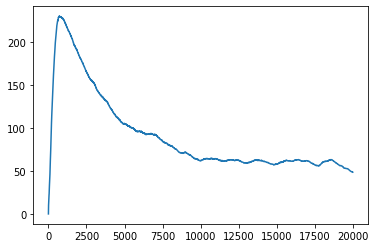

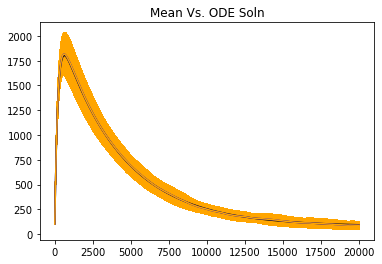

In [162]:
#find RMS

avg_p = avg_p.reshape(20000,1)
y_err = np.sqrt((((p_data - avg_p)**2).sum(axis=1))/(no_of_trials-1))

plt.plot(t_new, y)
plt.show()

plt.title('Mean Vs. ODE Soln')
plt.errorbar(t_new, avg_p, yerr = y_err, color = 'orange')
plt.plot(tvals, p_t, color = 'black')
plt.plot(t_new, avg_p, color = 'blue')
plt.show()